In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Linear Advection

The equations of hydrodynamics are a system of nonlinear partial differential equations that involve advection of mass, momentum, and energy.  To get a feel for the solution of these equations, we will start with the simple *linear advection equation*:

$$a_t + u a_x = 0$$

This requires initial conditions, $a(x, t=0)$, and a boundary condition.  The solution to this is easy to write down:

$$a(x, t) = a(x - ut)$$

any initial profile $a(\xi)$ is simply advected to the right (for $u > 0$) at a velocity $u$.

## Representing Data

We'll divide our domain into a grid and store the function value at each point in our grid:

![finite-difference grid](fd_grid.png)

and we use the notation $a_i^n = a(x_i,t^n)$ to represent the discrete data in space and time.

## A First Attempt

We might try to build on what we have already learned:

  * a centered difference for $a_x$ is second-order accurate, so that should be desirable for discretizing
    the spatial terms
    
  * we can do a simple explict Euler method to update the solution in time.

This would look like:

$$\frac{a_i^{n+1} - a_i^n}{\Delta t} = -u \frac{a_{i+1}^n - a_{i-1}^n}{2\Delta x}$$

This is an explicit update (the righthand side depends only on the information at the old time&mdash;stuff we know).  As this is first order in time and second order in space, this method is called FTCS.

We can rewrite this as:

$$a_i^{n+1} = a_i^n - \frac{C}{2} (a_{i+1}^n - a_{i-1}^n)$$

where we introduce the Courant number, $C$:

$$C = \frac{u\Delta t}{\Delta x}$$

this is dimensionless and is a measure of what fraction of a zone we cross per timestep.  

Now imagine that our grid has `N` points, numbered `0`, `1`, ... `N`.  When we do the update for `a[0]`, the equation above says we need information from zone `a[-1]`&mdash;this is outside our domain.  To accommodate this, and allow us to use the same equation to update all zones, we extend the domain past the boundary, creating *ghost points*:

![finite-difference ghost points](fd_ghost.png)

The ghost points are used to implement boundary conditions.  For instance, if we are periodic, then that means that $a_0^n = a_{N-1}^n$, so we would set:

$$a_N^n = a_1^n$$
$$a_{-1}^n = a_{N-2}^n$$

## Test problem

To test our solver, we would like a problem with a known solution at any future point in time.  For advection, this is easy, since the advection equation preserves any initial function and just moves it to the right (for $u > 0$) at a velocity $u$.  Therefore, we can use periodic boundary conditions on a domain $[0, 1]$ and advect for a time $1/u$, one periodic, and we should get back exactly what we started with.

## Grid class

To start, let's make a class that controls our grid and holds our data, and knows how to fill our periodic boundary conditions.

In [28]:
class FDGrid:
    """a finite-difference grid"""

    def __init__(self, nx, ng=1, xmin=0.0, xmax=1.0):
        """create a grid with nx points, ng ghost points (on each end)
        that runs from [xmin, xmax]"""

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy integers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords
        self.dx = (xmax - xmin)/(nx-1)
        self.x = xmin + (np.arange(nx+2*ng)-ng)*self.dx

        # storage for the solution
        self.a = np.zeros((nx+2*ng), dtype=np.float64)
        self.ainit = np.zeros((nx+2*ng), dtype=np.float64)
        
    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the a single ghostcell with periodic boundary conditions """
        self.a[self.ilo-1] = self.a[self.ihi-1]
        self.a[self.ihi+1] = self.a[self.ilo+1]
        
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)

        ax.plot(self.x, self.ainit, label="initial conditions")
        ax.plot(self.x, self.a)
        ax.legend()
        return fig

## FTCS

Now we can write our solver.  It will create the grid object, initialize the data (by calling a function we pass in) and then advance the solution using FTCS.

In [29]:
def ftcs_advection(nx, u, C, num_periods=1.0, init_cond=None):
    """solve the linear advection equation using FTCS.  You are required
    to pass in a function f(g), where g is a FDGrid object that sets up
    the initial conditions"""
    
    g = FDGrid(nx)
    
    # time info
    dt = C*g.dx/u
    t = 0.0
    tmax = num_periods*(g.xmax - g.xmin)/u

    # initialize the data
    init_cond(g)

    g.ainit[:] = g.a[:]
    
    # evolution loop
    anew = g.scratch_array()

    while t < tmax:

        if t + dt > tmax:
            dt = tmax - t
            C = u*dt/g.dx

        # fill the boundary conditions
        g.fill_BCs()

        # loop over zones: note since we are periodic and both endpoints
        # are on the computational domain boundary, we don't have to
        # update both g.ilo and g.ihi -- we could set them equal instead.
        # But this is more general
        for i in range(g.ilo, g.ihi+1):
            anew[i] = g.a[i] - 0.5*C*(g.a[i+1] - g.a[i-1])

        # store the updated solution
        g.a[:] = anew[:]

        t += dt

    return g

Now we need a function to initialize the state.  We'll do a tophat

In [30]:
def tophat(g):
    g.a[:] = 0.0
    g.a[np.logical_and(g.x >= 1./3, g.x <= 2./3.)] = 1.0

Let's try this out

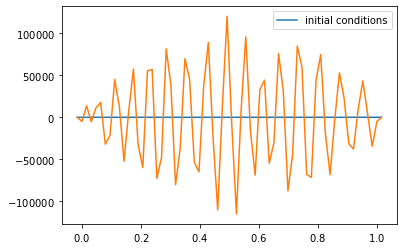

In [32]:
nx = 64
u = 1.0
C = 0.5

g = ftcs_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

That looks really bad!  Remember, if we did well, then the solution after one period should look just like the initial conditions!

We know that our difference approximations should be more accurate for smaller $\Delta t$ and smaller $\Delta x$.  Reducing $\Delta t$ is equivalent to picking a smaller value of $C$.  So let's try that.

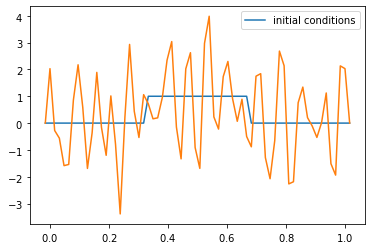

In [33]:
C = 0.1
g = ftcs_advection(nx, u, C, init_cond=tophat)
fig = g.plot()

That's still really bad.  Let's try evolving for less time:

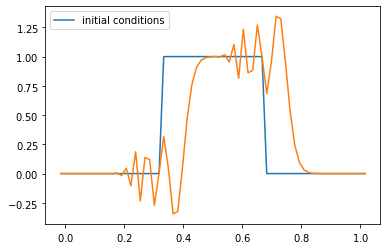

In [34]:
g = ftcs_advection(nx, u, C, init_cond=tophat, num_periods=0.1)
fig = g.plot()

That shows that something is happening near the discontinuities.  Maybe we need more resolution?

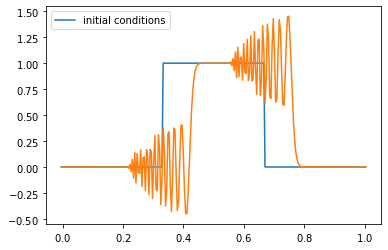

In [36]:
nx = 256
g = ftcs_advection(nx, u, C, init_cond=tophat, num_periods=0.1)
fig = g.plot()

## Stability

The issue is that the FTCS method is unstable.  There are different ways that we can analyze this.  We'll do a *truncation analysis*.

Let's start with our discrete equation:

$$a_i^{n+1} = a_i^n - \frac{C}{2} (a_{i+1}^n - a_{i-1}^n)$$

consider the Taylor expansions in space and time:

$$a_{i\pm 1}^n = a_i^n \pm a_x \Delta x + \frac{1}{2} a_{xx} \Delta x^2 + \mathcal{O}(\Delta x^3)$$

$$a_i^{n+1} = a_i^n + a_t \Delta t + \frac{1}{2} a_{tt} \Delta t^2 + \mathcal{O}(\Delta t^3)$$

we can replace the $a_tt$ time derivatives in the later expansion with the analytic equation:

$$a_t = -u a_x$$

$$a_{tt} = -u \frac{\partial}{\partial t} \frac{\partial a}{\partial x} = u^2 a_{xx}$$

and we have:

$$a_i^{n+1} = a_i^n + a_t \Delta t + \frac{1}{2} u^2 a_{xx} \Delta t^2 + \mathcal{O}(\Delta t^3)$$

Now substituting these into our original discrete equation:

$$a_i^n + a_t \Delta t + \frac{1}{2} u^2 a_{xx} \Delta t^2 + \mathcal{O}(\Delta t^3) = a_i^n - \frac{C}{2} (2 a_x \Delta x) + \mathcal{O}(\Delta x^3)$$

or simplifying:

$$a_t + u a_x = -\frac{1}{2} u^2 \Delta t a_{xx} + \mathcal{O}(\Delta t^2) + \mathcal{O}(\Delta x^3)$$

The left side looks like our original linear advection equation.  But when we keep some of the terms in our Taylor expansion, we see that our discrete equation more properly represents an advection equation with a term proportional to $a_{xx}$ on the righthand side.  This looks like a diffusion term.  The action of diffusion is to take a peaked distribution and smear it out over time.  But our diffusion term has a negative coefficient, so it is more like antidiffusion.  This is unphysical.  And there is no value of $\Delta t$ that makes the diffusion positive, therefore this system is always unstable.


## Upwinding

Let's try a different discretization.  We can approximate the space derivative using a one-sided difference as either:

$$ (a_x)_i \approx \frac{a_i - a_{i-1}}{\Delta x} + \mathcal{O}(\Delta x)$$

$$ (a_x)_i \approx \frac{a_{i+1} - a_i}{\Delta x} + \mathcal{O}(\Delta x)$$

We'll choose the one that is an *upwinded* difference&mdash;this means we want to make use of the points from the direction that information is flowing.  In our case, $u > 0$, so we want to use the points to the left of $i$ in approximating our derivative.

Chosing this difference makes us first-order accurate in space and time.  Our difference equation is:

$$\frac{a_i^{n+1} - a_i^n}{\Delta t} = - u \frac{a_i^n - a_{i-1}^n}{\Delta x}$$

<div class="alert alert-block alert-info">

**Exercise:**

Implement the first-order upwind method for linear advection and run the top hat initial conditions&mdash;how does the solution compare to FTCS?
    
</div>

## Convergence

In order to see whether our methods are working as designed, we need to be able to measure the convergence rate.  With the ODE orbit problem, we had a single point (the current position of Earth) at the end of our integration.  Now we have $N$ points at the new time.  So we need to define a metric that allows us to quantify the error.

We'll define a vector norm, the $L_2$ norm, for a set of discrete data $\phi_i$, as:

$$\|\phi\|_2 = \left ( \Delta x \sum_{i=0}^{N-1} \phi_i^2 \right )^{1/2}$$

and then we can define an error as $e_i = a_i - a^\mathrm{exact}(x_i)$ for all the points in our domain and compute an error, $\epsilon$ as $\| e\|_2$.  Further, for our problem, after 1 period, we know that the exact solution is just the initial data, so we can write:

$$\epsilon = \| a_i^\mathrm{final} - a_i^\mathrm{initial} \|_2
   = \left ( \Delta x \sum_{i=0}^{N-1} (a_i^\mathrm{final} - a_i^\mathrm{initial} )^2 \right )^{1/2}$$

<div class="alert alert-block alert-info">

**Exercise:**

Compute the $L_2$ norm of the error for our upwind method.  In order for it to make sense, we need to use smooth data, so pick the initial conditions as:

$$a(x, t=0) = \sin(2\pi x)$$
    
Now vary the number of grid points and measure the error and estimate the rate at which it converges.
    
</div>

## Characteristics

![advection characteristics](advection-characteristics.png)